In [3]:
from PIL import Image
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19
from torchvision.transforms import RandomCrop, ToTensor, Resize,Normalize, Compose
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from skimage.metrics import structural_similarity as ssim
from torchvision import transforms

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
class ImageDataset(Dataset):
    def __init__(self, hr_dir, crop_size=96, upscale_factor=4):
        self.hr_dir = hr_dir
        self.hr_files = os.listdir(hr_dir)
        self.hr_transform = RandomCrop(crop_size)
        self.upscale_factor = upscale_factor
        self.lr_size = crop_size // upscale_factor
        self.lr_transform = Resize((self.lr_size, self.lr_size), interpolation=Image.BICUBIC)
    
    def __len__(self):
        return len(self.hr_files)
    
    def __getitem__(self, idx):
        hr_name = os.path.join(self.hr_dir, self.hr_files[idx])
        # hr_img = Image.open(hr_name).convert('RGB')
        hr_img = Image.open(hr_name).convert('YCbCr')
        hr_y, cb, cr = hr_img.split()
        hr_y = self.hr_transform(hr_y)
        lr_y = self.lr_transform(hr_y)
        
        return {
            'hr_img': ToTensor()(hr_y),
            'lr_img': ToTensor()(lr_y)
        }

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size=3, padding=1, stride=1):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(channels),
            nn.PReLU(),
            nn.Conv2d(channels, channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(channels)
        )
    
    def forward(self, x):
        return x + self.block(x)
    
class UpSample(nn.Module):
    def __init__(self, in_channels, kernel_size=3, padding=1, stride=1, upScale_factor=2):
        super(UpSample, self).__init__()
        self.upsample = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * (upScale_factor ** 2), kernel_size=kernel_size, stride=stride, padding=padding),
            nn.PixelShuffle(upScale_factor),
            nn.PReLU()
        )
    
    def forward(self, x):
        return self.upsample(x)
    
class Generator(nn.Module):
    def __init__(self, num_Res_blocks = 16, upScale_factor = 4, num_res_block_channels = 64):
        super(Generator, self).__init__()
        
        self.intial_block = nn.Sequential(
            nn.Conv2d(1, num_res_block_channels, kernel_size=9, stride=1, padding=4),
            nn.PReLU()
        )
        self.res_block = nn.Sequential(*[ResidualBlock(num_res_block_channels) for _ in range(num_Res_blocks)])
        self.post_res = nn.Sequential(
            nn.Conv2d(num_res_block_channels, num_res_block_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_res_block_channels)
        )
        self.upsample_block = nn.Sequential(*[UpSample(num_res_block_channels) for _ in range(upScale_factor // 2)])
        self.final = nn.Conv2d(num_res_block_channels, 1, kernel_size=9, stride=1, padding=4)
        
    def forward(self, x):
        initial = self.intial_block(x)
        res = self.res_block(initial)
        post_residual = self.post_res(res)
        x = initial + post_residual
        x = self.upsample_block(x)
        x = self.final(x)
        return torch.sigmoid(x)

In [7]:
class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_bn=True):
        super(DiscriminatorBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else None
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        
    def forward(self, x):
        x = self.conv(x)
        if self.bn:
            x = self.bn(x)
        x = self.lrelu(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_shape=(3,96,96)):
        super(Discriminator, self).__init__()
        self.features = nn.Sequential(
            DiscriminatorBlock(1, 64, use_bn=False),
            DiscriminatorBlock(64, 64, stride=2),
            DiscriminatorBlock(64, 128),
            DiscriminatorBlock(128, 128, stride=2),
            DiscriminatorBlock(128, 256),
            DiscriminatorBlock(256, 256, stride=2),
            DiscriminatorBlock(256, 512),
            DiscriminatorBlock(512, 512, stride=2),
        )
        
        self.output_shape = self.get_output_shape(input_shape)
        self.dense_block = nn.Sequential(
            nn.Linear(self.output_shape, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )
    
    def get_output_shape(self, input_shape):
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            output = self.features(dummy)
            return int(torch.prod(torch.tensor(output.shape[1:])))
    
    def forward(self, x):
        features = self.features(x)
        flat = features.view(features.size(0), -1)
        return self.dense_block(flat)

In [8]:
class ContentLoss(nn.Module):
    def __init__(self):
        super(ContentLoss, self).__init__()
        vgg = vgg19(pretrained=True).features
        self.vgg_layers = nn.Sequential(*list(vgg)[:9]).eval()
        for param in self.vgg_layers.parameters():
            param.requires_grad = False
        
        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))
    
    def forward(self, sr, hr):
        sr_norm = (sr - self.mean) / self.std
        hr_norm = (hr - self.mean) / self.std
        sr_vgg = self.vgg_layers(sr_norm)
        hr_vgg = self.vgg_layers(hr_norm)
        return F.mse_loss(sr_vgg, hr_vgg)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

dataset = ImageDataset(hr_dir="DIV2K_train_HR", crop_size=192)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

generator = Generator().to(device)
discriminator = Discriminator(input_shape=(1,192,192)).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=1e-4,  betas=(0.9, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4,  betas=(0.9, 0.999))
scheduler_G = StepLR(optimizer_G, step_size=25, gamma=0.5)
scheduler_D = StepLR(optimizer_G, step_size=25, gamma=0.5)

criterion_content_loss = ContentLoss().to(device)

bce_loss_G = nn.BCELoss()
bce_loss_D = nn.BCELoss()
pixel_loss = nn.L1Loss() 

num_epochs = 100

cuda


/users/pg24/manivannan/miniconda3/envs/newEnv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/pg24/manivannan/miniconda3/envs/newEnv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
generator.to(device)
discriminator.to(device)

mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

for epoch in range(50):  # Pre-train
    for i, batch in enumerate(dataloader):
        lr_imgs = batch['lr_img'].to(device)
        hr_imgs = batch['hr_img'].to(device)
        
        optimizer_G.zero_grad()
        sr_imgs = generator(lr_imgs)
        loss = pixel_loss(sr_imgs, hr_imgs)
        loss.backward()
        optimizer_G.step()
        
        if i % 10 == 0:
            print(f"Pre-train Epoch {epoch}, Batch {i}, Pixel Loss: {loss.item():.6f}")


for epoch in range(num_epochs):
    for i, imgs in enumerate(dataloader):
        
        lr_patch = imgs["lr_img"].to(device)
        hr_patch = imgs["hr_img"].to(device)
        
        # Train Discriminator
        optimizer_D.zero_grad()
        with torch.no_grad():
            sr_patch = generator(lr_patch.detach())
        real_output = discriminator(hr_patch)
        fake_output = discriminator(sr_patch)
        
        #label_smoothing
        real_labels = torch.ones_like(real_output) * 0.9
        fake_labels = torch.zeros_like(fake_output) + 0.1
        
        loss_real = bce_loss_D(real_output, real_labels)
        loss_fake = bce_loss_D(fake_output, fake_labels)
        d_loss = loss_real + loss_fake
        d_loss.backward()
        optimizer_D.step()
        
        
        # Train Generator
        optimizer_G.zero_grad()
        
        sr_patch = generator(lr_patch)
        fake_output = discriminator(sr_patch)

        sr_norm = (sr_patch - mean) / std
        hr_norm = (hr_patch - mean) / std
        
        content_loss = criterion_content_loss(sr_patch, hr_patch)
        adverserial_loss = bce_loss_G(fake_output, torch.ones_like(fake_output))
        
        g_loss = content_loss + (1e-2 * adverserial_loss)
        g_loss.backward()
        optimizer_G.step()

        if i % 10 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Step {i}, G Loss: {g_loss.item()}, D Loss: {d_loss.item()}")
    
    scheduler_G.step()
    scheduler_D.step()

Pre-train Epoch 0, Batch 0, Pixel Loss: 0.246930
Pre-train Epoch 0, Batch 10, Pixel Loss: 0.075872
Pre-train Epoch 0, Batch 20, Pixel Loss: 0.078197
Pre-train Epoch 0, Batch 30, Pixel Loss: 0.053865
Pre-train Epoch 0, Batch 40, Pixel Loss: 0.095371
Pre-train Epoch 1, Batch 0, Pixel Loss: 0.114773
Pre-train Epoch 1, Batch 10, Pixel Loss: 0.078573
Pre-train Epoch 1, Batch 20, Pixel Loss: 0.089568
Pre-train Epoch 1, Batch 30, Pixel Loss: 0.074166
Pre-train Epoch 1, Batch 40, Pixel Loss: 0.053645
Pre-train Epoch 2, Batch 0, Pixel Loss: 0.048847
Pre-train Epoch 2, Batch 10, Pixel Loss: 0.072073
Pre-train Epoch 2, Batch 20, Pixel Loss: 0.086399
Pre-train Epoch 2, Batch 30, Pixel Loss: 0.062378
Pre-train Epoch 2, Batch 40, Pixel Loss: 0.069585
Pre-train Epoch 3, Batch 0, Pixel Loss: 0.096012
Pre-train Epoch 3, Batch 10, Pixel Loss: 0.061985
Pre-train Epoch 3, Batch 20, Pixel Loss: 0.039514
Pre-train Epoch 3, Batch 30, Pixel Loss: 0.059621
Pre-train Epoch 3, Batch 40, Pixel Loss: 0.098742
Pre-

In [ ]:
torch.save(generator.state_dict(), 'SRGAN_x4.pth')

In [11]:
def inference(generator, hr_dir, lr_dir):
    val_files = os.listdir(hr_dir)

    hr_images = []
    hr_y_s = []
    sr_y_s = []
    cr_images = []
    cb_images = []
    generator.eval()
    with torch.no_grad():
        for file in val_files:
            hr_name = os.path.join(hr_dir, file)
            lr_name = os.path.join(lr_dir, file)
            hr_img = Image.open(hr_name).convert('YCbCr')
            hr_images.append(hr_img)
            hr_y,_,_ = hr_img.split()
            hr_y = ToTensor()(hr_y)
            hr_y_s.append(hr_y)
            lr_img = Image.open(lr_name).convert('YCbCr')
            lr_y,lr_cb,lr_cr = lr_img.split()
            lr_y = ToTensor()(lr_y).to(device)
            cr_images.append(lr_cr)
            cb_images.append(lr_cb)
            
            sr_y = generator(lr_y.unsqueeze(0))
            sr_y_s.append(sr_y.squeeze(0).cpu())
    return hr_images, hr_y_s, sr_y_s, cr_images, cb_images

def calculate_psnr(sr, hr):
    mse = F.mse_loss(sr, hr)
    return 10 * torch.log10(1.0 / mse)

def calculate_ssim(sr, hr):
    sr_np = sr.permute(1, 2, 0).numpy()
    hr_np = hr.permute(1, 2, 0).numpy()
    
    sr_np = np.clip(sr_np, 0, 1)
    hr_np = np.clip(hr_np, 0, 1)
    
    return ssim(sr_np, hr_np, data_range=1.0, channel_axis=2, multichannel=True)

def test(generator, hr_dir, lr_dir):
    hr_images, hr_y_s, sr_y_s, cr_images, cb_images = inference(generator, hr_dir, lr_dir)
    psnr_errors = []
    SSIM_errors = []
    for i in range(len(hr_y_s)):
        psnr_errors.append(calculate_psnr(sr_y_s[i], hr_y_s[i]).item())
        SSIM_errors.append(calculate_ssim(sr_y_s[i], hr_y_s[i]).item())
    
    return np.mean(psnr_errors), np.mean(SSIM_errors)

In [ ]:
generator = Generator().to(device)
generator.load_state_dict(torch.load("SRGAN_x4.pth"))
generator.eval()

/tmp/ipykernel_1318583/1348745653.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("SRGAN_x4_1.pth"))


Generator(
  (intial_block): Sequential(
    (0): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (res_block): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

In [14]:
hr_dir = "DIV2K_valid_HR"
lr_dir = "DIV2K_valid_LR_bicubic_X4"
psnr, SSIM = test(generator, hr_dir, lr_dir)
print(f'for the DIV2K validation set the PSNR is {psnr} and SSIM is {SSIM}')

for the DIV2K validation set the PSNR is 26.740964221954346 and SSIM is 0.7600513061881066


In [15]:
hr_dir = "Set5/HR"
lr_dir = "Set5/LR"
psnr, SSIM = test(generator, hr_dir, lr_dir)
print(f'for the Set5 dataset the PSNR is {psnr} and SSIM is {SSIM}')

for the Set5 dataset the PSNR is 27.57843933105469 and SSIM is 0.8219052672386169


In [16]:
hr_dir = "Set14/HR"
lr_dir = "Set14/LR"
psnr, SSIM = test(generator, hr_dir, lr_dir)
print(f'for the Set14 dataset the PSNR is {psnr} and SSIM is {SSIM}')

for the Set14 dataset the PSNR is 24.914567674909318 and SSIM is 0.7013699071747916


In [21]:

val_files = os.listdir("Set5/HR")

generator.eval()
with torch.no_grad():
        hr_name = os.path.join(hr_dir, val_files[2])
        lr_name = os.path.join(lr_dir, val_files[2])
        hr_img = Image.open(hr_name).convert('YCbCr')
        hr_y,_,_ = hr_img.split()
        lr_img = Image.open(lr_name).convert('YCbCr')
        lr_y,lr_cb,lr_cr = lr_img.split()
        lr_y = ToTensor()(lr_y).to(device)
        
        sr_y = generator(lr_y.unsqueeze(0))
        sr_y = sr_y.squeeze(0).cpu()

sr_y_np = sr_y.squeeze().cpu().clamp(0, 1).numpy() * 255.0
sr_y_np = sr_y_np.astype(np.uint8)
sr_y_img = Image.fromarray(sr_y_np, mode='L')

new_size = sr_y_img.size
cb_up = lr_cb.resize(new_size, Image.BICUBIC)
cr_up = lr_cr.resize(new_size, Image.BICUBIC)

img_ycbcr = Image.merge("YCbCr", [sr_y_img, cb_up, cr_up])
img_rgb = img_ycbcr.convert("RGB")
hr_img_rgb = hr_img.convert("RGB")

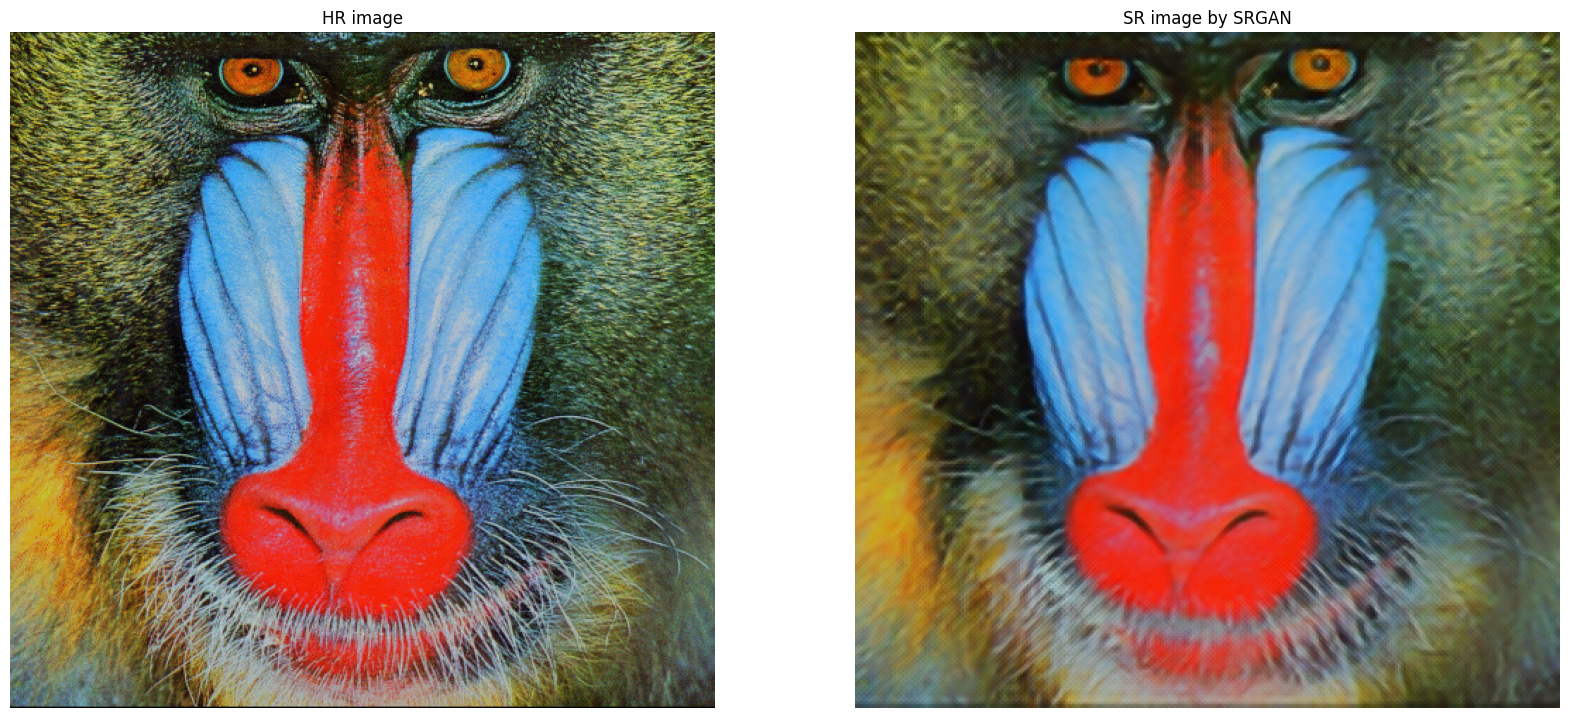

In [31]:
fig, ax = plt.subplots(1,2, figsize=(20, 10))

ax[0].imshow(hr_img_rgb)
ax[0].axis("off")
ax[0].set_title("HR image")

ax[1].imshow(img_rgb)
ax[1].axis("off")
ax[1].set_title("SR image by SRGAN")

plt.show()
fig.savefig("compare_images_SRGAN.png")

In [24]:
img_rgb.save("SR_image_SRGAN.png")